In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facialexpressionrecognition/fer2013.csv


In [22]:
import os
import matplotlib.pyplot as plt
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization, Activation,LSTM,Conv1D,MaxPooling1D
from keras.utils import to_categorical
from keras.optimizers import Adam
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv('../input/facialexpressionrecognition/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [4]:
df = data.copy()

In [5]:
df['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


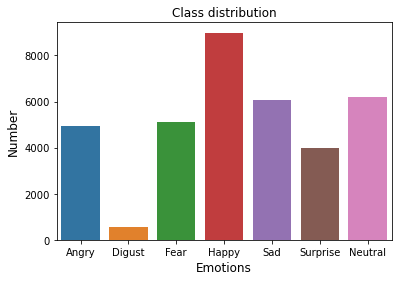

In [7]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

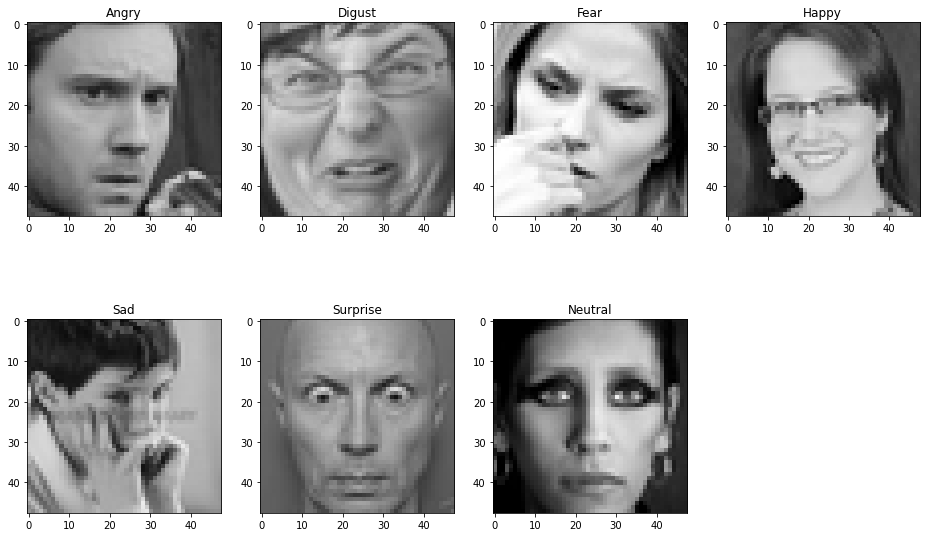

In [8]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [9]:
data_train = data[data["Usage"] == "Training"].copy()
data_val = data[data["Usage"] == "PublicTest"].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print(data_train.shape,
data_val.shape,
data_test.shape)

(28709, 3) (3589, 3) (3589, 3)


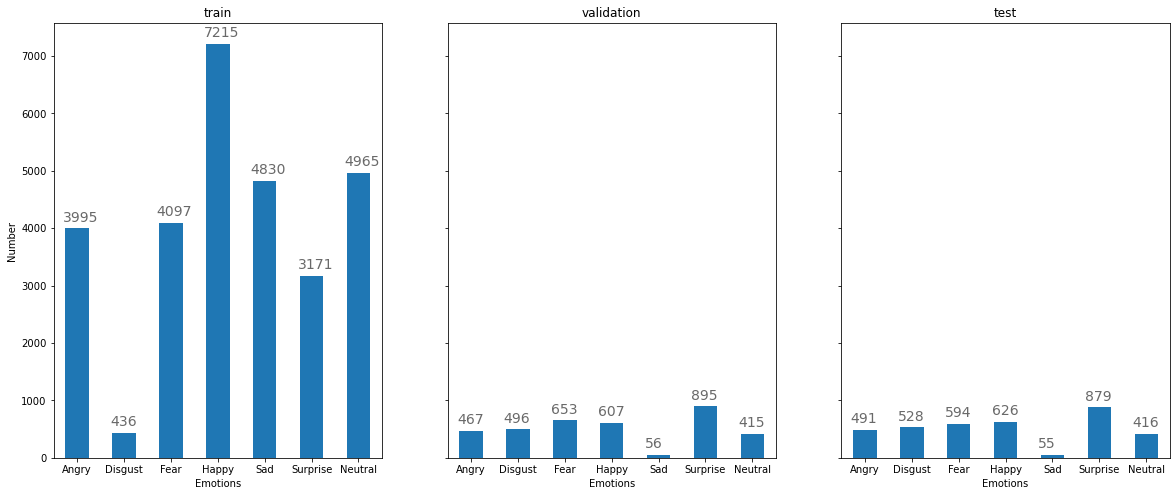

In [10]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [11]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [12]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [13]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

In [14]:
model = Sequential()

#module 1
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)       

In [16]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

In [17]:
history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
449/448 - 18s - loss: 1.6532 - accuracy: 0.3440 - val_loss: 1.6934 - val_accuracy: 0.3210
Epoch 2/50
449/448 - 18s - loss: 1.3457 - accuracy: 0.4816 - val_loss: 1.3176 - val_accuracy: 0.4948
Epoch 3/50
449/448 - 18s - loss: 1.2214 - accuracy: 0.5332 - val_loss: 1.2267 - val_accuracy: 0.5339
Epoch 4/50
449/448 - 17s - loss: 1.1460 - accuracy: 0.5637 - val_loss: 1.4577 - val_accuracy: 0.4982
Epoch 5/50
449/448 - 18s - loss: 1.0978 - accuracy: 0.5832 - val_loss: 1.1443 - val_accuracy: 0.5670
Epoch 6/50
449/448 - 17s - loss: 1.0537 - accuracy: 0.5984 - val_loss: 1.2359 - val_accuracy: 0.5508
Epoch 7/50
449/448 - 17s - loss: 1.0215 - accuracy: 0.6127 - val_loss: 1.1482 - val_accuracy: 0.5815
Epoch 8/50
449/448 - 17s - loss: 0.9955 - accuracy: 0.6227 - val_loss: 1.0751 - val_accuracy: 0.6018
Epoch 9/50
449/448 - 18s - loss: 0.9755 - accuracy: 0.6299 - val_loss: 1.1423 - val_accuracy: 0.5979
Epoch 10/50
449/448 - 17s - loss: 0.9518 - accuracy: 0.6450 - val_loss: 1.0633 - val_accura

In [18]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6746


LSTM HYBRID


In [47]:
model = Sequential()

#module 1
model.add(Conv1D(64, kernel_size=3, input_shape=(width, height), data_format='channels_last'))
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(64, kernel_size=3, padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv1D(128, kernel_size=3, padding='same'))
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(128, kernel_size=3, padding='same'))
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv1D(256, kernel_size=3, padding='same'))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(256, kernel_size=3, padding='same'))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

NameError: name 'width' is not defined

In [28]:
model = Sequential()

model.add(Conv2D(32, 4, activation='relu', padding='same', input_shape=(4, 1)))
model.add(LSTM(32, return_sequences=True))
model.add(MaxPooling2D(2))
model.add(Conv2D(16, 8, activation="relu", padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(MaxPooling2D(2))
model.add(Conv2D(16, 8, activation="relu", padding='same'))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ValueError: Input 0 of layer conv2d_12 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 4, 1]

GAN

In [33]:
# load and plot faces
from os import listdir
from numpy import asarray
from PIL import Image
from matplotlib import pyplot

# load an image as an rgb numpy array
def load_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    return pixels

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # load the image
        pixels = load_image(directory + filename)
        # store
        faces.append(pixels)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces)

# plot a list of loaded faces
def plot_faces(faces, n):
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(faces[i])
    pyplot.show()

# directory that contains all images
directory = '../input/facialexpressionrecognition/fer2013.csv'
# load and extract all faces
faces = load_faces(directory, 25)
print('Loaded: ', faces.shape)
# plot faces
plot_faces(faces, 5)

NotADirectoryError: [Errno 20] Not a directory: '../input/facialexpressionrecognition/fer2013.csv'

HYBRID

In [29]:
import numpy as np
import pandas as pd 

import os
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D,MaxPooling1D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [2]:
x = pd.read_csv('../input/facialexpressionrecognition/fer2013.csv')
print(x.shape)

(35887, 3)


In [3]:
data = x.values
print (data.shape)
print (data[0, 0])

(35887, 3)
0


In [4]:
y = data[:, 0]
pixels = data[:, 1]
print (type(pixels))
print (len(pixels[0]))
print (pixels[10][10])

<class 'numpy.ndarray'>
8287
3


In [5]:
X = np.zeros((pixels.shape[0], 48*48))

for ix in range(X.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(X.shape[1]):
        X[ix, iy] = int(p[iy])

In [6]:
X

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 17.,  17.,  16., ..., 154., 133., 113.],
       [ 30.,  28.,  28., ...,  35.,  30.,  28.],
       [ 19.,  13.,  14., ..., 189., 199., 201.]])

In [7]:
y.shape

(35887,)

In [8]:
x = X

In [9]:
x = x/255

In [10]:
X_train = x[0:28709, :]
Y_train = y[0:28709]
print (X_train.shape, Y_train.shape)
X_crossval = x[28709:32298, :]
Y_crossval = y[28709:32298]
print (X_crossval.shape, Y_crossval.shape)
X_test = x[32299:, :]
Y_test = y[32299:]
print(X_test.shape, Y_test.shape)

(28709, 2304) (28709,)
(3589, 2304) (3589,)
(3588, 2304) (3588,)


In [11]:
X_train = X_train.reshape((X_train.shape[0], 48, 48,1 ))
X_crossval = X_crossval.reshape((X_crossval.shape[0], 48, 48,1))
X_test = X_test.reshape((X_test.shape[0],48,48,1))

In [12]:
print (y.shape)
y_ = np_utils.to_categorical(y, 7)
print (y_.shape)

(35887,)
(35887, 7)


In [13]:
Y_train = y_[:28709]
Y_crossval = y_[28709:32298]
Y_test = y_[32299:]
print (X_crossval.shape, Y_crossval.shape,Y_test.shape)

(3589, 48, 48, 1) (3589, 7) (3588, 7)


In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(X_train)

In [15]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [64]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1),padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(256, (5, 5), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, (5, 5), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(512, (5,5), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(512, (5,5), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [30]:
model = Sequential()

model.add(Conv1D(64, 3, activation='relu', input_shape=(48,1),padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv1D(64, 3, activation='relu',padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Conv1D(128, 3, activation='relu',padding='same'))
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv1D(128, 3, activation='relu',padding='same'))
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))


model.add(Conv1D(256, 5, activation='relu',padding='same'))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv1D(256, 5, activation='relu',padding='same'))
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))


model.add(Conv1D(512, 5, activation='relu',padding='same'))
model.add(LSTM(512, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv1D(512, 5, activation='relu',padding='same'))
model.add(LSTM(512, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd)
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [44]:

model = Sequential()

model.add(Conv1D(32, 4, activation='relu', padding='same', input_shape=(48,48)))
model.add(LSTM(32, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(64, return_sequences=True))
model.add(MaxPooling1D(2))
model.add(Conv1D(16, 8, activation="relu", padding='same'))
model.add(LSTM(128))
model.add(Dense(7, activation='sigmoid'))

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:

history = model.fit(X_train, Y_train, batch_size=10, epochs=epochs)

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_14 is incompatible with the layer: expected axis -1 of input shape to have value 48 but received input with shape [None, 48, 48, 1]


In [31]:
batch_size = 48
epochs = 50

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
steps_per_epoch = len(X) // batch_size
validation_steps = len((X_crossval, Y_crossval)) // batch_size

In [32]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=X.shape[0] // batch_size,
                    callbacks=[lr_reduce],
                    validation_data=(X_crossval, Y_crossval),
                    epochs = epochs, verbose = 2)

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer lstm_6 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, None, None, 64]


In [69]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.3567


In [14]:
from keras.models import Model
layer_name='my_dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 48, 48, 32)       

In [15]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = False,
    zoom_range = 0.20)

In [16]:
from keras.optimizers import Adam, Adadelta, RMSprop

model.compile(loss='categorical_crossentropy',optimizer=Adadelta(),metrics=['accuracy'])

datagen.fit(train_image)

# training
history = model.fit_generator(datagen.flow(train_image,train_label, batch_size=64),
                              epochs = 50,
                              shuffle=True,
                              validation_data = (val_image,val_label),
                              verbose = 1,
                              steps_per_epoch=train_image.shape[0] // 32)

NameError: name 'train_image' is not defined

NEW TRY

In [1]:
import numpy as np
import pandas as pd 

import os
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../input/facialexpressionrecognition/fer2013.csv')
print(data.shape)

(35887, 3)


In [3]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [4]:
data[data['Usage']=='Training']

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...,Training
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,Training
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training


In [3]:
train_data = data[data['Usage']=='Training']
val_data = data[data['Usage']=='PublicTest']
test_data = data[data['Usage']=='PrivateTest']
train_label = np.float32(train_data.emotion)
val_label = np.float32(val_data.emotion)
test_label = np.float32(test_data.emotion)

In [4]:
np.float32(train_data.emotion)

array([0., 0., 2., ..., 4., 0., 4.], dtype=float32)

In [21]:
train_label

array([0., 0., 2., ..., 4., 0., 4.], dtype=float32)

In [ ]:
val_data = val_data.drop(['Usage'],axis=1)

In [26]:
train_data = train_data.drop(['Usage'],axis=1)
val_data = val_data.drop(['Usage'],axis=1)
test_data = test_data.drop(['Usage'],axis=1)

KeyError: "['Usage'] not found in axis"

In [20]:
test_data

,emotion,pixels
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...
...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [6]:
a = train_data.pixels.str.split(" ",expand=True,)
b = val_data.pixels.str.split(" ",expand=True,)
c = test_data.pixels.str.split(" ",expand=True,)

In [23]:
c

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
32298,170,118,101,88,88,75,78,82,66,74,...,210,210,222,222,204,190,174,159,133,131
32299,7,5,8,6,7,3,2,6,5,4,...,41,37,76,88,84,88,82,72,57,52
32300,232,240,241,239,237,235,246,117,24,24,...,64,21,89,68,46,67,2,4,4,9
32301,200,197,149,139,156,89,111,58,62,95,...,142,161,185,185,107,146,144,149,33,0
32302,40,28,33,56,45,33,31,78,152,194,...,25,26,29,26,28,25,24,24,29,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35882,50,36,17,22,23,29,33,39,34,37,...,216,215,216,217,221,222,220,223,221,216
35883,178,174,172,173,181,188,191,194,196,199,...,147,141,136,118,66,7,0,0,0,0
35884,17,17,16,23,28,22,19,17,25,26,...,190,179,193,193,194,170,148,154,133,113
35885,30,28,28,29,31,30,42,68,79,81,...,30,27,27,26,28,35,35,35,30,28


In [62]:
train_data[train_data.columns[1]]

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
28704    84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705    114 112 113 113 111 111 112 113 115 113 114 11...
28706    74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707    222 227 203 90 86 90 84 77 94 87 99 119 134 14...
28708    195 199 205 206 205 203 206 209 208 210 212 21...
Name: pixels, Length: 28709, dtype: object

In [8]:
train_image = np.float32(a[a.columns[0:]])
val_image = np.float32(b[b.columns[0:]])
test_image = np.float32(c[c.columns[0:]])

In [9]:
print('train shape: %s'%str(train_data.shape))
print('val shape: %s'%str(val_data.shape))
print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))
print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))
print('test_image shape: %s'%str(test_image.shape))

train shape: (28709, 2)
val shape: (3589, 2)
train_label shape: (28709,)
val_label shape: (3589,)
train_image shape: (28709, 2304)
val_image shape: (3589, 2304)
test_image shape: (3589, 2304)


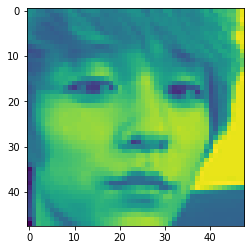

(2304,)
train_image shape: (28709, 48, 48, 1)
train_image shape: (28709, 48, 48, 1)
val_image shape: (3589, 48, 48, 1)


In [10]:
plt.imshow(train_image[13].reshape(48,48))
plt.show()
print(train_image[13].shape)

train_image = train_image/255.0
val_image = val_image/255.0
test_image = test_image/255.0

train_image = train_image.reshape(train_image.shape[0],48,48,1)
val_image = val_image.reshape(val_image.shape[0],48,48,1)
test_image = test_image.reshape(test_image.shape[0],48,48,1)
print('train_image shape: %s'%str(train_image.shape))

print('train_image shape: %s'%str(train_image.shape))
print('val_image shape: %s'%str(val_image.shape))

train_label1 = train_label
val_label1 = val_label

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False,categories='auto')
yy = [[0],[1],[2],[3],[4],[5],[6]]
encoder.fit(yy)
# transform
train_label = train_label.reshape(-1,1)
val_label = val_label.reshape(-1,1)


train_label = encoder.transform(train_label)
val_label = encoder.transform(val_label)



print('train_label shape: %s'%str(train_label.shape))
print('val_label shape: %s'%str(val_label.shape))

train_label shape: (28709, 7)
val_label shape: (3589, 7)


In [12]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers import LeakyReLU

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1),padding='same'))
# model.add(LSTM(32, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
# model.add(LSTM(32, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(5,5), activation='relu',padding='same'))
# model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, (5,5), activation='relu',padding='same'))
# model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(256, (5,5), activation='relu',padding='same'))
# model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, (5,5), activation='relu',padding='same'))
# model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [14]:
from keras.models import Model
layer_name='my_dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 32)       

In [15]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 15,
    horizontal_flip = False,
    zoom_range = 0.20)

In [16]:
from keras.optimizers import Adam, Adadelta, RMSprop

model.compile(loss='categorical_crossentropy',optimizer=Adadelta(),metrics=['accuracy'])

# datagen.fit(train_image)

# # training
# history = model.fit_generator(datagen.flow(train_image,train_label, batch_size=32),
#                               epochs = 50,
#                               shuffle=True,
#                               validation_data = (val_image,val_label),
#                               verbose = 1,
#                               steps_per_epoch=train_image.shape[0] // 32)

batch_size = 48
epochs = 50

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
steps_per_epoch = len(train_image) // batch_size
validation_steps = len((val_image, val_label)) // batch_size

history = model.fit_generator(datagen.flow(train_image, train_label, batch_size=batch_size),
                    steps_per_epoch=train_image.shape[0] // batch_size,
                    validation_data=(val_image, val_label),
                    epochs = epochs, verbose = 2)

Epoch 1/50
598/598 - 21s - loss: 0.3869 - accuracy: 0.2485 - val_loss: 0.3754 - val_accuracy: 0.2948
Epoch 2/50
598/598 - 21s - loss: 0.3691 - accuracy: 0.3159 - val_loss: 0.3447 - val_accuracy: 0.3831
Epoch 3/50
598/598 - 22s - loss: 0.3474 - accuracy: 0.3701 - val_loss: 0.3184 - val_accuracy: 0.4140
Epoch 4/50
598/598 - 21s - loss: 0.3333 - accuracy: 0.4086 - val_loss: 0.3076 - val_accuracy: 0.4536
Epoch 5/50
598/598 - 22s - loss: 0.3256 - accuracy: 0.4264 - val_loss: 0.2999 - val_accuracy: 0.4664
Epoch 6/50
598/598 - 22s - loss: 0.3194 - accuracy: 0.4397 - val_loss: 0.2956 - val_accuracy: 0.4873
Epoch 7/50
598/598 - 21s - loss: 0.3112 - accuracy: 0.4640 - val_loss: 0.2828 - val_accuracy: 0.5113
Epoch 8/50
598/598 - 22s - loss: 0.3043 - accuracy: 0.4827 - val_loss: 0.2750 - val_accuracy: 0.5291
Epoch 9/50
598/598 - 21s - loss: 0.2987 - accuracy: 0.4944 - val_loss: 0.2728 - val_accuracy: 0.5283
Epoch 10/50
598/598 - 21s - loss: 0.2948 - accuracy: 0.5089 - val_loss: 0.2714 - val_accura

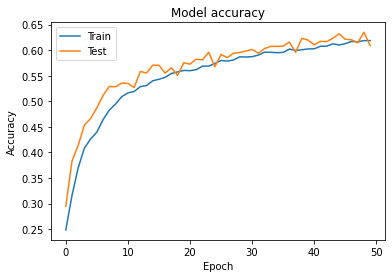

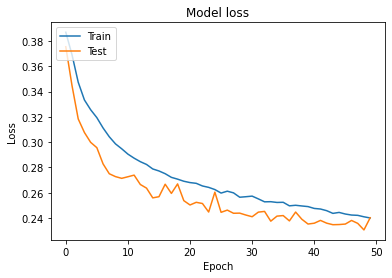

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
intermediate_output = intermediate_layer_model.predict(train_image) 
intermediate_output = pd.DataFrame(data=intermediate_output)

In [19]:
intermediate_output

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.000000,0.000000,0.570070,0.0,0.000000,0.482380,0.0,0.000000,0.000000,0.286393,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.186082,0.0,0.000000,0.160554,0.0,0.109980,0.194428,0.005013,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.021161
2,0.000000,0.000000,0.270687,0.0,0.000000,0.019620,0.0,0.004261,0.000000,0.000000,...,0.088530,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.093326,0.0,0.037682,0.000000,0.000000,...,0.350830,0.000000,0.139510,0.0,0.085914,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.366587,...,0.396866,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28704,0.350856,0.000000,0.000000,0.0,0.226945,0.000000,0.0,0.269736,0.357404,0.000000,...,0.000000,0.068053,0.065776,0.0,0.000000,0.0,0.0,0.115581,0.093266,0.000000
28705,0.000000,0.000000,0.345033,0.0,0.000000,0.511158,0.0,0.000000,0.000000,0.274867,...,0.000000,0.000000,0.000000,0.0,0.061166,0.0,0.0,0.000000,0.000000,0.000000
28706,0.000000,0.658306,0.635723,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.279950,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.441635
28707,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.143774,...,0.140854,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [20]:
val_data = intermediate_output

In [25]:
val_data

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.000000,0.000000,0.570070,0.0,0.000000,0.482380,0.0,0.000000,0.000000,0.286393,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.186082,0.0,0.000000,0.160554,0.0,0.109980,0.194428,0.005013,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.021161
2,0.000000,0.000000,0.270687,0.0,0.000000,0.019620,0.0,0.004261,0.000000,0.000000,...,0.088530,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.093326,0.0,0.037682,0.000000,0.000000,...,0.350830,0.000000,0.139510,0.0,0.085914,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.366587,...,0.396866,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28704,0.350856,0.000000,0.000000,0.0,0.226945,0.000000,0.0,0.269736,0.357404,0.000000,...,0.000000,0.068053,0.065776,0.0,0.000000,0.0,0.0,0.115581,0.093266,0.000000
28705,0.000000,0.000000,0.345033,0.0,0.000000,0.511158,0.0,0.000000,0.000000,0.274867,...,0.000000,0.000000,0.000000,0.0,0.061166,0.0,0.0,0.000000,0.000000,0.000000
28706,0.000000,0.658306,0.635723,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.279950,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.441635
28707,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.143774,...,0.140854,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [21]:
submission_cnn = model.predict(test_image)

In [22]:
submission_cnn

array([[3.45814079e-01, 3.12307440e-02, 1.42487317e-01, ...,
        2.69847304e-01, 1.54307438e-02, 1.87040299e-01],
       [1.96950167e-01, 1.02522243e-02, 1.20727561e-01, ...,
        3.92881066e-01, 1.11739766e-02, 2.07299814e-01],
       [5.43208495e-02, 6.78783108e-04, 1.22942217e-01, ...,
        7.08016276e-01, 7.96711247e-04, 1.12188235e-01],
       ...,
       [1.21515013e-01, 2.97339028e-03, 9.11168009e-02, ...,
        1.91163927e-01, 1.85466930e-02, 5.40854394e-01],
       [5.22155128e-03, 3.63632025e-05, 1.94717676e-03, ...,
        7.33783655e-03, 1.91145635e-03, 2.55720407e-01],
       [2.77576476e-01, 2.15453915e-02, 1.93306223e-01, ...,
        3.69601756e-01, 8.52525886e-03, 1.27688393e-01]], dtype=float32)

In [23]:
intermediate_test_output = intermediate_layer_model.predict(test_image)
intermediate_test_output = pd.DataFrame(data=intermediate_test_output)

In [24]:
from xgboost import XGBClassifier

xgbmodel = XGBClassifier(objective='multi:softprob', 
                      num_class= 10)
xgbmodel.fit(intermediate_output, train_label1)
xgbmodel.score(val_data, val_label1)

ValueError: Found input variables with inconsistent numbers of samples: [3589, 28709]

In [ ]:
intermediate_layer_model.predict(test_image)

In [ ]:
submission_xgb = xgbmodel.predict(intermediate_test_output)

GNB

In [ ]:
from sklearn.naive_bayes import GaussianNB 
gnbmodel = GaussianNB().fit(intermediate_output, train_label1) 

submission_gnb = gnbmodel.predict(intermediate_test_output) 
gnbmodel.score(val_data, val_label1)

In [46]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [47]:
batch_size = 64
epochs = 50

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
steps_per_epoch = len(train_image) // batch_size
validation_steps = len((val_image, val_label)) // batch_size

history = model.fit_generator(datagen.flow(train_image, train_label, batch_size=batch_size),
                    steps_per_epoch=train_image.shape[0] // batch_size,
                    callbacks=[lr_reduce],
                    validation_data=(val_image, val_label),
                    epochs = epochs, verbose = 2)

Epoch 1/50
448/448 - 20s - loss: 0.2387 - accuracy: 0.6194 - val_loss: 0.2305 - val_accuracy: 0.6361
Epoch 2/50
448/448 - 20s - loss: 0.2379 - accuracy: 0.6250 - val_loss: 0.2337 - val_accuracy: 0.6225
Epoch 3/50
448/448 - 20s - loss: 0.2359 - accuracy: 0.6261 - val_loss: 0.2334 - val_accuracy: 0.6264
Epoch 4/50
448/448 - 20s - loss: 0.2361 - accuracy: 0.6272 - val_loss: 0.2351 - val_accuracy: 0.6305
Epoch 5/50
448/448 - 19s - loss: 0.2335 - accuracy: 0.6326 - val_loss: 0.2300 - val_accuracy: 0.6442
Epoch 6/50
448/448 - 20s - loss: 0.2336 - accuracy: 0.6339 - val_loss: 0.2245 - val_accuracy: 0.6464
Epoch 7/50
448/448 - 20s - loss: 0.2330 - accuracy: 0.6327 - val_loss: 0.2315 - val_accuracy: 0.6445
Epoch 8/50
448/448 - 19s - loss: 0.2323 - accuracy: 0.6345 - val_loss: 0.2288 - val_accuracy: 0.6383
Epoch 9/50
448/448 - 21s - loss: 0.2318 - accuracy: 0.6348 - val_loss: 0.2351 - val_accuracy: 0.6339
Epoch 10/50
448/448 - 20s - loss: 0.2314 - accuracy: 0.6346 - val_loss: 0.2315 - val_accura